In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import os
os.makedirs("../out", exist_ok=True)

from tqdm import tqdm

# Q3: Efficient Tracking

Make sure to comment your code and use proper names for your variables.

## Q3.1: Lucas-Kanade with Inverse Composition

In [13]:
from scipy.ndimage import affine_transform
import cv2

from scipy.interpolate import RectBivariateSpline
def InverseCompositionAffine(It, It1, threshold, num_iters):
    """
    :param[np.array(H, W)] It   : Image frame at time-step t
    :param[np.array(H, W)] It1  : Image frame at time-step t+1
    :param[float] threshold     : If the length of dp < threshold, terminate the optimization
    :param[int] num_iters       : Number of iterations for running the optimization
    
    :return[np.array(2, 3)] M   : Affine warp matrix
    """
    # Initial M
    # M = np.eye(3)
    M = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0]])

    # ----------------------------------------------------------------------------------------------
    # TODO: Add your Efficient LK implementation here: 
    # Pre-compute:
    # Evaluate the gradient of the template 
    gradient_y,gradient_x=np.gradient(It)
    # Evaluate the Jacobian, Compute the steepest descent images 
    y=np.arange(0,It.shape[0])
    x=np.arange(0,It.shape[1])
    xv,yv=np.meshgrid(x,y)
    gradient_x=gradient_x.reshape(1,-1)[0]
    gradient_y=gradient_y.reshape(1,-1)[0]
    xv=xv.reshape(1,-1)[0]
    yv=yv.reshape(1,-1)[0]
    A=[]
    A1=[]
    A2=[]
    A3=[]
    A4=[]
    for i in range(len(gradient_x)):
        A1.append(gradient_x[i]*xv[i])
        A2.append(gradient_y[i]*xv[i])
        A3.append(gradient_x[i]*yv[i])
        A4.append(gradient_y[i]*yv[i])
    A.append(A1)
    A.append(A3)
    A.append(gradient_x.tolist())
    A.append(A2)
    A.append(A4)
    A.append(gradient_y.tolist())
    A=np.array(A)
    #print(A.shape)
    # transpose
    A=np.transpose(A,(1,0))
    # Compute the inverse Hessian matrix using Equation 
    H = A.T @ A
    H_inv = np.linalg.inv(H)
    delta_threshold=2
    times = 0
    mode1 = RectBivariateSpline(y, x, It1)

    while ( delta_threshold>= threshold) and (times<num_iters):
        #computed only on the pixels lying in the region common to It and the warped version of It+1.
        M_x = M[0]
        M_y = M[1]
        new_x = M_x[0] * xv + M_x[1] * yv+M_x[2]
        new_y = M_y[0] * xv + M_y[1] * yv+M_y[2]
        x_region = np.logical_and(new_x>0,new_x<It.shape[1])
        y_region = np.logical_and(new_y>0,new_y<It.shape[0])
        in_region = np.logical_and(x_region,y_region)
       
        # warp I with W
        h, w= It1.shape
        # It_warp= cv2.warpAffine(It1,M,(w,h))
        new_x = new_x[in_region]
        new_y = new_y[in_region]
        It_warp=mode1(new_y,new_x,grid=False)
        # get error image
        # tmplate in region
        b_tmp=It.reshape(in_region.shape)[in_region]
        b_tmp=b_tmp.reshape(-1,1)
        b_new_I = It_warp.reshape(-1,1)
        b=b_new_I-b_tmp

        # make A and b in region -> dimension matching
        A_new = A[in_region]
        # use formula-> get H
        H = A_new.T @ A_new
        # inverse H
        H_inv = np.linalg.inv(H)
        # formula to get delta_p
        tmp = A_new.T @ b
        delta_p = H_inv @ tmp

        # update delta_m
        delta_M = np.array([[delta_p[0][0]+1,delta_p[1][0],delta_p[2][0]],
                            [delta_p[3][0],1+delta_p[4][0],delta_p[5][0]],
                            [0,0,1]])
        #Update the w
        M = M @ np.linalg.inv(delta_M)
        delta_p_th=delta_p.reshape(1,-1)[0]
        
        delta_threshold=np.linalg.norm(delta_p_th)
        times+=1
    # ----------------------------------------------------------------------------------------------
    return M

## Q3.1 Subtract Dominant Motion

Re-use your implementation for Q2.2. 

Just make sure to use InverseCompositionAffine within. 

In [14]:
from scipy.ndimage import binary_erosion, binary_dilation, affine_transform
import cv2

def SubtractDominantMotion(It, It1, num_iters, threshold, tolerance):
    """
    :param[np.array(H, W)] It   : Image frame at time-step t
    :param[np.array(H, W)] It1  : Image frame at time-step t+1
    :param[float] threshold     : For LucasKanadeAffine --> If the length of dp < threshold, 
                                  terminate the optimization
    :param[int] num_iters       : For LucasKanadeAffine --> Number of iterations for running the 
                                  optimization
    :param[float] tolerance     : Binary threshold of intensity difference when computing the mask.
   
    :return[np.array(H, W)] mask: Binary mask indicating moving pixels. 
    """
    mask = np.ones(It1.shape, dtype=bool)

    # ----------------------------------------------------------------------------------------------
    # TODO: Add your code here:
    m=InverseCompositionAffine(It,It1,threshold,num_iters)
    #print(m)

    #print(m.shape)

    #computed only on the pixels lying in the region common to It and the warped version of It+1.
    m_x = m[0]
    m_y = m[1]
    y=np.arange(0,It.shape[0])
    x=np.arange(0,It.shape[1])
    xv,yv=np.meshgrid(x,y)
    new_x = m_x[0] * xv + m_x[1] * yv+m_x[2]
    new_y = m_y[0] * xv + m_y[1] * yv+m_y[2]
    x_region = np.logical_and(new_x>0,new_x<It.shape[1])
    y_region = np.logical_and(new_y>0,new_y<It.shape[0])
    in_region = np.logical_and(x_region,y_region)


    #print(m)
    #1. Warp the image It using M
    #m_inv = np.linalg.inv(m)
    #It_warp = affine_transform(It,m_inv)
    h, w= It.shape
    It_warp= cv2.warpAffine(It,m,(w,h))


    # Subtract the warped image from It+1
    It_diff = np.abs(It_warp-It1)
    # mask function to get 0 or 1
    def mask(x,tol):
        if x < tol:
            return False
        else:
            return True
    func = np.vectorize(mask)
    mask = func(It_diff,tolerance)

    # not in region-> false
    mask[~in_region] = False

    # better looking
    kernel_e = np.ones((3,3))
    kernel_d = np.ones((4,4))
    #mask=binary_erosion(mask,kernel_e)#,iterations=1)
    mask=binary_dilation(mask,kernel_d,iterations=2)
    mask=binary_erosion(mask,kernel_e,iterations=2)
    # print(mask)

    # ----------------------------------------------------------------------------------------------
    return mask 

(-0.5, 255.5, 255.5, -0.5)

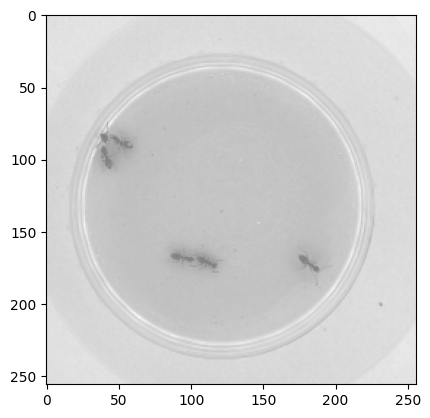

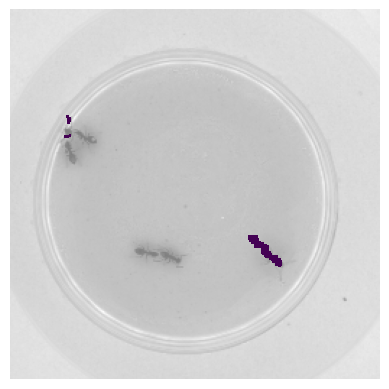

In [15]:
# test for one
seq = np.load("../data/antseq.npy")
plt.imshow(seq[:,:,91], cmap="gray", alpha=0.5)
mask=SubtractDominantMotion(seq[:,:,90],seq[:,:,91],1000,0.01,0.2)
plt.figure()
plt.imshow(seq[:,:,91], cmap="gray", alpha=0.5)
plt.imshow(np.ma.masked_where(np.invert(mask), mask))
plt.axis('off')
#plt.savefig(f"../out/sol_2.3_antseq_{idx+1}.png")

## Q3.2: Track Sequence

Re-use your implementation for Q2.3

In [16]:
def TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance):
    """
    :param[np.array(H, W, N)] seq : sequence of frames
    :param[int] num_iters         : Number of iterations for running the optimization
    :param[float] threshold       : If the length of dp < threshold, terminate the optimization
    :param[float] tolerance       : Binary threshold of intensity difference when computing the mask.

    :return[np.array(H, W)] mask: Binary mask indicating moving pixels.
    """
    H, W, N = seq.shape

    masks = []
    It = seq[:,:,0]

    # ----------------------------------------------------------------------------------------------
    # TODO: Add your code here:
    for i in tqdm(range(1, seq.shape[2])):
        mask = SubtractDominantMotion(seq[:,:,i-1],seq[:,:,i],num_iters,threshold,tolerance)
        masks.append(mask)

    # ----------------------------------------------------------------------------------------------
    masks = np.stack(masks, axis=2)
    return masks

### Q3.2: Track Ant Sequence

Feel free to play with these snippets of code; run ablations, visualize a gif with the whole sequence, etc.

Just make sure the bounding boxes for the car are clearly visible, and report those of the frames we requested. 

In [17]:
seq = np.load("../data/antseq.npy")

# NOTE: feel free to play with these parameters
num_iters = 1e4
threshold = 1e-2
tolerance = 0.2

masks = TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance)
np.save(f'../out/antseqmasks.npy', masks)

100%|██████████| 124/124 [00:43<00:00,  2.84it/s]


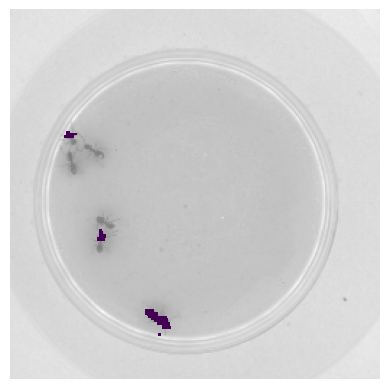

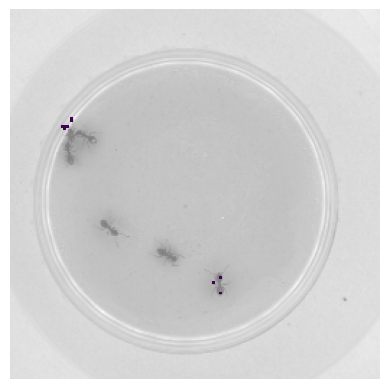

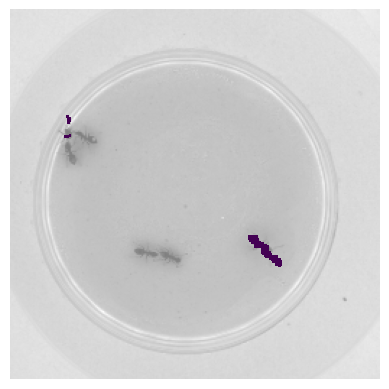

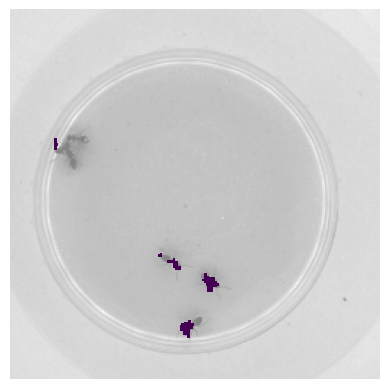

In [18]:
# TODO: visualize. Re-use your implementation for Q2.3
frames_to_save = [30, 60, 90, 120]
seq= np.load("../data/antseq.npy")
masks=np.load("../out/antseqmasks.npy")

for idx in frames_to_save:
    #pass
    frame = seq[:,:,idx]
    mask = masks[:,:,idx]
   
    plt.figure()
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.imshow(np.ma.masked_where(np.invert(mask), mask))
    plt.axis('off')
    plt.savefig(f"../out/sol_3.2_antseq_{idx+1}.png")

### Q3.2: Test Aerial Sequence

Feel free to play with these snippets of code; run ablations, visualize a gif with the whole sequence, etc.

Just make sure the bounding boxes for the car are clearly visible, and report those of the frames we requested. 

In [19]:
seq = np.load("../data/aerialseq.npy")

# NOTE: feel free to play with these parameters
num_iters = 1e3
threshold = 1e-2
tolerance = 0.2

masks = TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance)
np.save(f'../out/aerialseqmasks.npy', masks)

100%|██████████| 149/149 [01:09<00:00,  2.14it/s]


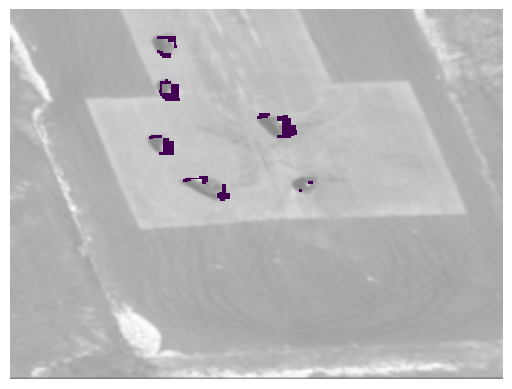

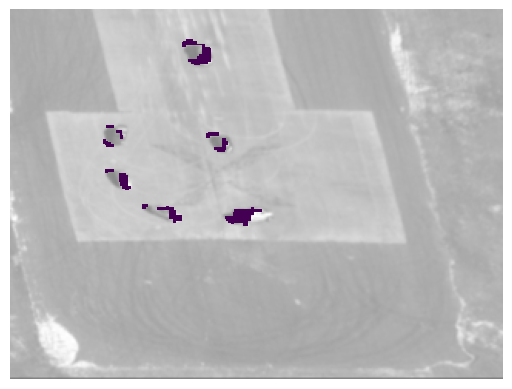

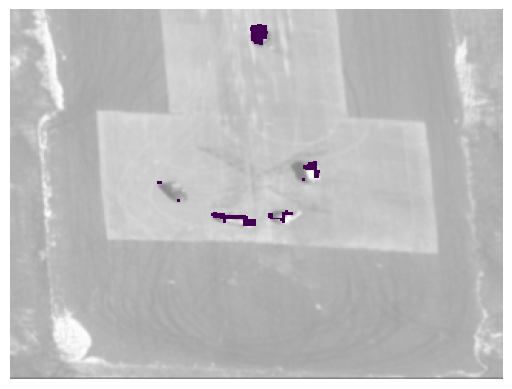

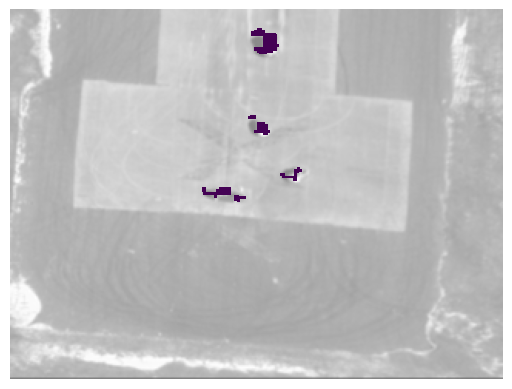

In [20]:
# TODO: visualize. Re-use your implementation for Q2.3
frames_to_save = [30, 60, 90, 120]
seq= np.load("../data/aerialseq.npy")
masks=np.load("../out/aerialseqmasks.npy")

for idx in frames_to_save:
    #pass
    frame = seq[:,:,idx]
    mask = masks[:,:,idx]
   
    plt.figure()
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.imshow(np.ma.masked_where(np.invert(mask), mask))
    plt.axis('off')
    plt.savefig(f"../out/sol_3.2_aerialseq_{idx+1}.png")